#Querying Out-of-Core datasets

> Objectives:
> * Compare queries of tabular data for **on-disk** containers
> * Compare sizes and times for those

In [1]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [1] used 0.031 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 28.902 MiB


## Load movielens datasets in pandas DataFrames

In [1]:
import os
dset = 'movielens-1m'
fdata = os.path.join(dset, 'ratings.dat.gz')
fitem = os.path.join(dset, 'movies.dat')

In [2]:
# Import CSV files via pandas
import pandas as pd
# pass in column names for each CSV
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(fdata, sep=';', names=r_cols, compression='gzip')

m_cols = ['movie_id', 'title', 'genres']
movies = pd.read_csv(fitem, sep=';', names=m_cols,
                     dtype={'title': "S100", 'genres': "S100"})

In [4]:
# Store movies and ratings in 2 separate tables in SQLite
sqlite_norm = "movielens-norm.sqlite"
if os.path.exists(sqlite_norm):
    os.unlink(sqlite_norm)
import sqlite3
conn = sqlite3.connect(sqlite_norm)
conn.text_factory = str   # Shut up problems with Unicode
ratings.to_sql("ratings", conn)
movies.to_sql("movies", conn)
conn.close()

In [4] used 117.125 MiB RAM in 4.921s, peaked 122.703 MiB above current, total RAM usage 224.109 MiB


In [5]:
# create one merged DataFrame
lens = pd.merge(movies, ratings)

In [5] used 85.145 MiB RAM in 0.175s, peaked 0.000 MiB above current, total RAM usage 309.254 MiB


In [96]:
lens.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 6 columns):
movie_id          1000209 non-null int64
title             1000209 non-null object
genres            1000209 non-null object
user_id           1000209 non-null int64
rating            1000209 non-null int64
unix_timestamp    1000209 non-null int64
dtypes: int64(4), object(2)
memory usage: 53.4+ MB
In [96] used 0.000 MiB RAM in 0.175s, peaked 0.000 MiB above current, total RAM usage 415.676 MiB


In [6]:
# Store lens denormalized in 1 table in SQLite
sqlite_denorm = "movielens-denorm.sqlite"
if os.path.exists(sqlite_denorm):
    os.unlink(sqlite_denorm)
conn_denorm = sqlite3.connect(sqlite_denorm)
conn_denorm.text_factory = str   # Shut up problems with Unicode
lens.to_sql("lens", conn_denorm)
conn_denorm.close()

In [6] used 54.512 MiB RAM in 5.843s, peaked 168.918 MiB above current, total RAM usage 363.766 MiB


In [7]:
del movies, ratings

In [7] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 363.766 MiB


In [8]:
%time result = lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']

CPU times: user 106 ms, sys: 4.13 ms, total: 110 ms
Wall time: 122 ms
In [8] used 22.859 MiB RAM in 0.126s, peaked 0.000 MiB above current, total RAM usage 386.625 MiB


In [9]:
# keep the run-time for reference
qtime_pandas_mem = mw.measurements.time_delta
# ...and print the result (for reference too)
result

5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64

In [9] used 0.000 MiB RAM in 0.018s, peaked 0.000 MiB above current, total RAM usage 386.625 MiB


## Querying on-disk data with SQLite (relational database)

In [10]:
# Execute the query with the de-normalized SQLite database
conn = sqlite3.connect(sqlite_denorm)
c = conn.cursor()

In [10] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 386.625 MiB


In [11]:
q = "select user_id from lens where title == 'Tom and Huck (1995)' and rating == 5"
%time result = [r for r in c.execute(q)]

CPU times: user 192 ms, sys: 36.1 ms, total: 228 ms
Wall time: 226 ms
In [11] used 0.004 MiB RAM in 0.231s, peaked 0.000 MiB above current, total RAM usage 386.629 MiB


In [12]:
# keep the run-time for reference
qtime_sqlite_denorm = mw.measurements.time_delta
# ...and print the result (for reference too)
result

[(75,), (3842,), (6031,)]

In [12] used 0.000 MiB RAM in 0.007s, peaked 0.000 MiB above current, total RAM usage 386.629 MiB


In [13]:
# Execute the query with the normalized SQLite database
conn = sqlite3.connect(sqlite_norm)
c = conn.cursor()

In [13] used 0.000 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 386.629 MiB


In [14]:
q = """
select ratings.user_id from movies 
INNER JOIN ratings ON movies.movie_id = ratings.movie_id
where movies.title == 'Tom and Huck (1995)' and ratings.rating == 5
"""
%time result = [r for r in c.execute(q)]

CPU times: user 2.39 s, sys: 1.34 s, total: 3.73 s
Wall time: 3.73 s
In [14] used 0.000 MiB RAM in 3.737s, peaked 0.000 MiB above current, total RAM usage 386.629 MiB


In [15]:
# keep the run-time for reference
qtime_sqlite_norm = mw.measurements.time_delta
# ...and print the result (for reference too)
result

[(75,), (3842,), (6031,)]

In [15] used 0.008 MiB RAM in 0.007s, peaked 0.000 MiB above current, total RAM usage 386.637 MiB


So in general, we see that it is much faster to query tables in denormalized form, although they take much more storage:

In [16]:
!ls -sh $sqlite_norm $sqlite_denorm

78M movielens-denorm.sqlite  37M movielens-norm.sqlite
In [16] used 0.234 MiB RAM in 0.121s, peaked 0.000 MiB above current, total RAM usage 386.871 MiB


In some way, storing tables in normalized form is a kind of compression, but that comes to the cost of using more time to process queries.  Let's enter another way to compress denormalized data tables on-disk:

## bcolz

`bcolz` cannot only deal with data in-memory, but also on-disk exactly in the same way.  Let's try that.

In [17]:
import bcolz
bcolz.print_versions()
bcolz.defaults.cparams['cname'] = 'lz4'
bcolz.defaults.cparams['clevel'] = 5
# bcolz.set_nthreads(4)

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
bcolz version:     0.9.0
NumPy version:     1.9.2
Blosc version:     1.4.1 ($Date:: 2014-07-08 #$)
Blosc compressors: ['blosclz', 'lz4', 'lz4hc', 'snappy', 'zlib']
Numexpr version:   2.4.3
Python version:    2.7.10 |Anaconda 2.1.0 (64-bit)| (default, May 28 2015, 17:02:03) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Platform:          linux2-x86_64
Byte-ordering:     little
Detected cores:    4
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
In [17] used 5.680 MiB RAM in 0.106s, peaked 0.000 MiB above current, total RAM usage 392.551 MiB


In [18]:
# Import a pandas DataFrame in a ctable on-disk
bcolz_dir = "movielens-denorm.bcolz"
if os.path.exists(bcolz_dir):
    import shutil
    shutil.rmtree(bcolz_dir)
zlens = bcolz.ctable.fromdataframe(lens, rootdir=bcolz_dir)

In [18] used 0.328 MiB RAM in 0.375s, peaked 140.605 MiB above current, total RAM usage 392.879 MiB


In [19]:
%time result = zlens["(title == 'Tom and Huck (1995)') & (rating == 5)"]['user_id']

CPU times: user 80.9 ms, sys: 10.7 ms, total: 91.6 ms
Wall time: 74 ms
In [19] used 0.062 MiB RAM in 0.076s, peaked 0.000 MiB above current, total RAM usage 392.941 MiB


In [20]:
# keep the run-time for reference
qtime_bcolz = mw.measurements.time_delta
# ...and print the result (for reference too)
result

array([  75, 3842, 6031])

In [20] used 0.000 MiB RAM in 0.008s, peaked 0.000 MiB above current, total RAM usage 392.941 MiB


In [21]:
# One can optimize the query more
%time result = [r.user_id for r in zlens.where("(title == 'Tom and Huck (1995)') & (rating == 5)", outcols=['user_id'])]

CPU times: user 91.9 ms, sys: 24.8 ms, total: 117 ms
Wall time: 84.1 ms
In [21] used 0.000 MiB RAM in 0.088s, peaked 0.000 MiB above current, total RAM usage 392.941 MiB


In [22]:
# keep the run-time for reference
qtime_bcolz_opt = mw.measurements.time_delta
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [22] used 0.000 MiB RAM in 0.008s, peaked 0.000 MiB above current, total RAM usage 392.941 MiB


Let's see the space consumed on-disk:

In [23]:
!du -sh $bcolz_dir

6,6M	movielens-denorm.bcolz
In [23] used 0.000 MiB RAM in 0.127s, peaked 0.000 MiB above current, total RAM usage 392.941 MiB


and let's compare it with the internal estimated size:

In [24]:
zlens

ctable((1000209,), [('movie_id', '<i8'), ('title', 'S82'), ('genres', 'S47'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])
  nbytes: 153.57 MB; cbytes: 7.89 MB; ratio: 19.45
  cparams := cparams(clevel=5, shuffle=True, cname='lz4')
  rootdir := 'movielens-denorm.bcolz'
[(1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496)
 ...,
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)]

In [24] used 0.016 MiB RAM in 0.011s, peaked 0.000 MiB above current, total RAM usage 392.957 MiB


So, the internal estimated size is a bit higher than the actual size on-disk, which is pretty good.

Another interesting fact is that the de-normalized version of the ctable takes less space than the normalized version in a relational database, and the query speed is still faster (than SQLite at least).

But there are other ways to store compressed tables.  Let's visit PyTables and how it performs:

## PyTables

In [25]:
h5denorm = "movielens-denorm.h5"
if os.path.exists(h5denorm):
    os.unlink(h5denorm)
zlens.tohdf5(h5denorm, nodepath='/h5lens')

In [25] used 0.426 MiB RAM in 0.520s, peaked 0.000 MiB above current, total RAM usage 393.383 MiB


In [26]:
import tables
h5file = tables.open_file(h5denorm)
h5lens = h5file.root.h5lens

In [26] used 0.027 MiB RAM in 0.015s, peaked 0.000 MiB above current, total RAM usage 393.410 MiB


In [27]:
# Let's have a look at the HDF5 table
h5lens

/h5lens (Table(1000209,), shuffle, blosc:lz4(5)) ''
  description := {
  "movie_id": Int64Col(shape=(), dflt=0, pos=0),
  "title": StringCol(itemsize=82, shape=(), dflt='', pos=1),
  "genres": StringCol(itemsize=47, shape=(), dflt='', pos=2),
  "user_id": Int64Col(shape=(), dflt=0, pos=3),
  "rating": Int64Col(shape=(), dflt=0, pos=4),
  "unix_timestamp": Int64Col(shape=(), dflt=0, pos=5)}
  byteorder := 'little'
  chunkshape := (407,)

In [27] used 0.004 MiB RAM in 0.007s, peaked 0.000 MiB above current, total RAM usage 393.414 MiB


In [28]:
%time result = [r['user_id'] for r in h5lens.where("(title == 'Tom and Huck (1995)') & (rating == 5)")]

CPU times: user 272 ms, sys: 17.3 ms, total: 289 ms
Wall time: 268 ms
In [28] used 0.031 MiB RAM in 0.271s, peaked 0.000 MiB above current, total RAM usage 393.445 MiB


In [29]:
# keep the run-time for reference
qtime_pytables = mw.measurements.time_delta
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [29] used 0.008 MiB RAM in 0.006s, peaked 0.000 MiB above current, total RAM usage 393.453 MiB


So, it seems that PyTables has a similar performance than SQLite for the queries (denormalized case).  What about the size of the HDF5 file?

In [30]:
h5file.close()
!ls -sh $h5denorm

7,1M movielens-denorm.h5
In [30] used 0.000 MiB RAM in 0.127s, peaked 0.000 MiB above current, total RAM usage 393.453 MiB


7.1 MB is very close to 6.6 MB that used bcolz (which is expected because both are using LZ4 as the compressor), and much less than .

Now, pandas comes with its own interface to PyTables via the HDFStore sub-package.  Let's check that out.

## HDFStore (pandas HDF5 via PyTables)

In [31]:
h5pandas = "movielens-pandas.h5"
if os.path.exists(h5pandas):
    os.unlink(h5pandas)
from pandas import HDFStore
hdf = HDFStore(h5pandas, complevel=5, complib="blosc:lz4")
hdf.put('h5lens', lens, format='table', data_columns=True)

In [31] used 41.438 MiB RAM in 11.143s, peaked 121.527 MiB above current, total RAM usage 434.891 MiB


In [32]:
print hdf['h5lens'].shape

(1000209, 6)
In [32] used 254.633 MiB RAM in 0.654s, peaked 42.113 MiB above current, total RAM usage 689.523 MiB


In [33]:
%time hdf.select('h5lens', where="(title == 'Tom and Huck (1995)') & (rating == 5)", columns=["user_id"])

CPU times: user 50.5 ms, sys: 28.2 ms, total: 78.7 ms
Wall time: 81.3 ms


,user_id
5121,75
5164,3842
5187,6031


In [33] used -275.676 MiB RAM in 0.090s, peaked 0.000 MiB above current, total RAM usage 413.848 MiB


In [34]:
# keep the run-time for reference
qtime_pandas_hdf5 = mw.measurements.time_delta
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [34] used 0.000 MiB RAM in 0.006s, peaked 0.000 MiB above current, total RAM usage 413.848 MiB


As we can see, the time is very close to the time that it takes the query on a pandas DataFrame in memory.  What about the size on-disk?

In [35]:
hdf.close()

In [35] used -0.250 MiB RAM in 0.206s, peaked 0.000 MiB above current, total RAM usage 413.598 MiB


In [37]:
!ls -sh $h5pandas

13M movielens-pandas.h5
In [37] used 0.000 MiB RAM in 0.123s, peaked 0.000 MiB above current, total RAM usage 413.703 MiB


Ok, so 13 MB is around 80% larger than a pure PyTables file with the same info (7.1 MB).  Where the overhead comes from?  Well, it turns out that pandas makes use of the indexing capabilities of PyTables automatically, so let's make PyTables to index the columns that participate in the query.

## Indexing (PyTables)

In [71]:
## Copy the original PyTables table into another file
h5idx = "movielens-indexed.h5"
if os.path.exists(h5idx):
    os.unlink(h5idx)
shutil.copyfile(h5denorm, h5idx)

In [71] used 0.000 MiB RAM in 0.015s, peaked 0.000 MiB above current, total RAM usage 411.598 MiB


In [72]:
# Open the new file in 'a'ppend mode
h5i = tables.open_file(h5idx, mode="a")

In [72] used 0.000 MiB RAM in 0.005s, peaked 0.000 MiB above current, total RAM usage 411.598 MiB


In [73]:
# Create an index for the 'title' column
h5lens = h5i.root.h5lens
h5lens.cols.title.create_csindex()

1000209

In [73] used 0.000 MiB RAM in 4.488s, peaked 119.445 MiB above current, total RAM usage 411.598 MiB


In [74]:
# ...and redo the query...
t = %timeit -r1 -n1 -o result = [r['user_id'] for r in h5lens.where("(title == 'Tom and Huck (1995)') & (rating == 5)")]

1 loops, best of 1: 7.52 ms per loop
In [74] used 0.000 MiB RAM in 0.015s, peaked 0.000 MiB above current, total RAM usage 411.598 MiB


In [75]:
# keep the run-time for reference
qtime_pytables_index1 = t.best
# ...and print the result (for reference too)
result

[(75,), (3842,), (6031,)]

In [75] used 0.000 MiB RAM in 0.008s, peaked 0.000 MiB above current, total RAM usage 411.598 MiB


So, by indexing one column we have got a 30x of acceleration wrt PyTables (11 vs 350 ms).  What happens if we index the 'rating' column?

In [76]:
h5lens.cols.rating.create_csindex()

1000209

In [76] used 0.000 MiB RAM in 0.872s, peaked 0.000 MiB above current, total RAM usage 411.598 MiB


In [77]:
t = %timeit -r1 -n1 -o result = [r['user_id'] for r in h5lens.where("(title == 'Tom and Huck (1995)') & (rating == 5)")]

1 loops, best of 1: 2.26 ms per loop
In [77] used 0.000 MiB RAM in 0.009s, peaked 0.000 MiB above current, total RAM usage 411.598 MiB


In [78]:
# keep the run-time for reference
qtime_pytables_index2 = t.best
# ...and print the result (for reference too)
result

[(75,), (3842,), (6031,)]

In [78] used 0.000 MiB RAM in 0.006s, peaked 0.000 MiB above current, total RAM usage 411.598 MiB


Ok, that's another ~5x additional acceleration, and the best time that we ever reached for this query.

In [79]:
h5i.close()

In [79] used 0.004 MiB RAM in 0.165s, peaked 0.000 MiB above current, total RAM usage 411.602 MiB


##Indexing (SQLite)

We are of course curious to find out how indexing in relational databases fares against PyTables' own indexing.

In [80]:
sqlite_idx = "movielens-indexed.sqlite"
if os.path.exists(sqlite_idx):
    os.unlink(sqlite_idx)
shutil.copyfile(sqlite_denorm, sqlite_idx)
conn_idx = sqlite3.connect(sqlite_idx)

In [80] used 0.000 MiB RAM in 0.167s, peaked 0.000 MiB above current, total RAM usage 411.602 MiB


In [81]:
c = conn_idx.cursor()
c.execute("CREATE INDEX index_title ON lens (title)")
conn_idx.commit()

In [81] used 0.000 MiB RAM in 3.557s, peaked 0.000 MiB above current, total RAM usage 411.602 MiB


In [82]:
q = "select user_id from lens where title == 'Tom and Huck (1995)' and rating == 5"
t = %timeit -r1 -n1 -o result = [r for r in c.execute(q)]

1 loops, best of 1: 555 µs per loop
In [82] used 0.000 MiB RAM in 0.007s, peaked 0.000 MiB above current, total RAM usage 411.602 MiB


In [83]:
# keep the run-time for reference
qtime_sqlite_index1 = t.best
# ...and print the result (for reference too)
result

[(75,), (3842,), (6031,)]

In [83] used 0.000 MiB RAM in 0.006s, peaked 0.000 MiB above current, total RAM usage 411.602 MiB


Wow, with ~.5 ms we are getting the best figure so far, and faster than the best figure with indexed PyTables.  Now, what will happen with indexing the second column?  We should get better speed, right?  Wrong!

In [84]:
c.execute("CREATE INDEX index_ratings ON lens (rating)")

In [84] used 0.000 MiB RAM in 1.719s, peaked 0.000 MiB above current, total RAM usage 411.602 MiB


In [85]:
q = "select user_id from lens where title == 'Tom and Huck (1995)' and rating == 5"
t = %timeit -r1 -n1 -o results = [r for r in c.execute(q)]

1 loops, best of 1: 219 ms per loop
In [85] used 0.000 MiB RAM in 0.226s, peaked 0.000 MiB above current, total RAM usage 411.602 MiB


In [86]:
# keep the run-time for reference
qtime_sqlite_index2 = t.best
# ...and print the result (for reference too)
result

[(75,), (3842,), (6031,)]

In [86] used 0.000 MiB RAM in 0.007s, peaked 0.000 MiB above current, total RAM usage 411.602 MiB


That's a not pleasant surprise: adding another index is decrasing the speed by a factor of 170x (!).

The leason to learn here is that indexing is tricky and you should always double check whether a new indexing operation is going to be beneficial for your use case.

In [87]:
conn_idx.close()

In [87] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 411.602 MiB


## Final performance comparison

In [89]:
%matplotlib inline

In [89] used 0.000 MiB RAM in 0.007s, peaked 0.000 MiB above current, total RAM usage 411.613 MiB


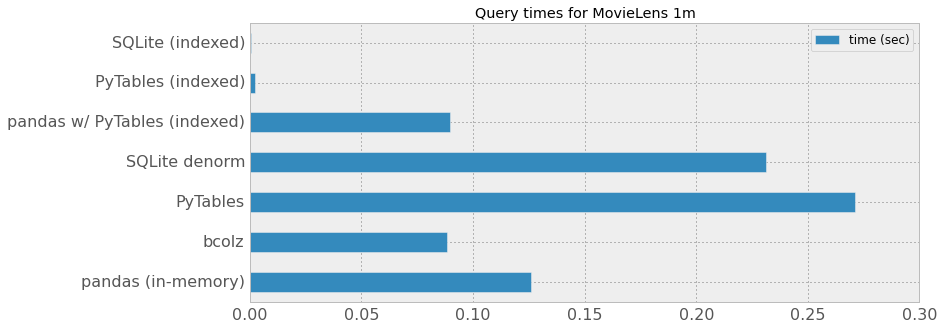

In [102] used 0.965 MiB RAM in 0.336s, peaked 0.000 MiB above current, total RAM usage 420.078 MiB


In [102]:
# Query times
labels = ["pandas (in-memory)", "bcolz", "PyTables", "SQLite denorm", "pandas w/ PyTables (indexed)", "PyTables (indexed)", "SQLite (indexed)"]
df = pd.DataFrame({'time (sec)': [qtime_pandas_mem, qtime_bcolz_opt, qtime_pytables, qtime_sqlite_denorm, qtime_pandas_hdf5, qtime_pytables_index2, qtime_sqlite_index1]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Query times for MovieLens 1m")

## Final size comparison

In [88]:
!du -sh movielens* | sort -nr

119M	movielens-indexed.sqlite
78M	movielens-denorm.sqlite
37M	movielens-norm.sqlite
13M	movielens-pandas.h5
11M	movielens-indexed.h5
7,1M	movielens-denorm.h5
6,6M	movielens-denorm.bcolz
6,6M	movielens.blz
In [88] used 0.012 MiB RAM in 0.136s, peaked 0.000 MiB above current, total RAM usage 411.613 MiB


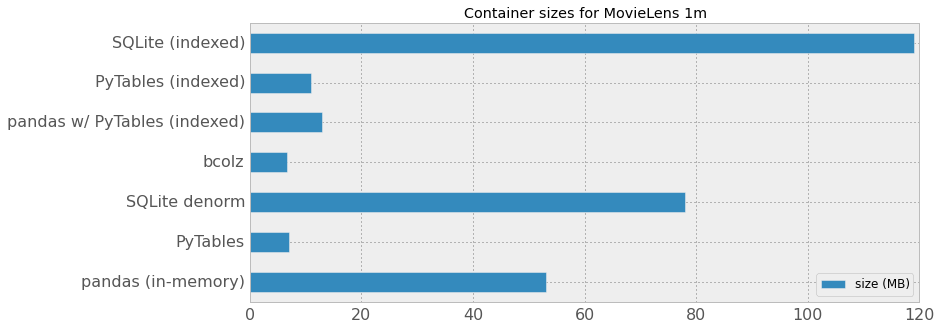

In [107] used 0.902 MiB RAM in 0.375s, peaked 0.000 MiB above current, total RAM usage 424.469 MiB


In [107]:
# Container sizes
df = pd.DataFrame({'size (MB)': [53, 7.1, 78, 6.6, 13, 11, 119]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Container sizes for MovieLens 1m")

# Data Containers Overview

Fortunately, there are many different solutions for storing large datasets both in-memory and on-disk.  Here it is a summary of the ones that we have seen in this tutorial:

* In-core
  * Python lists and dictionaries: Included in Python.  Very flexible.  Not efficient for large datasets.
  * NumPy: Good for large amounts of data and with a lot of functionality.  Does not support compression.
  * Pandas: Good for large amounts of data and with a lot of functionality.  Does not support compression.
  * bcolz: Good for large amounts of data, but reduced functionality.  Supports compression.
  
* Out-of-core
  * Pandas/HDFStore: Good for large datasets.  Supports indexing and compression.  Medium query speeds.
  * PyTables: Good for large datasets.  Supports indexing and compression.  Good query speeds.
  * bcolz: Good for large datasets.  Supports compression, but not indexing.  Medium query speeds.
  * SQLite: Can be used for large datasets, buttakes a lot of disk.  Supports compression, but indexing.  Excellent query speeds.

As you see, every solution has strengths and weaknesses, with wild variations in resource consumptions, so the wise thing to do is to know them better and try to apply the best candidate to your scenario.